<a href="https://colab.research.google.com/github/oplxy/ReinforcedArcade/blob/main/CHJHS_PyTorch_finetuning_OBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TorchVision Object Detection Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Fast R-CNN](https://ieeexplore.ieee.org/document/7410526/) model. It contains 17 images, and we will use it to illustrate how to use the new features in torchvision in order to train an objec detection model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-zwl4f50a
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-zwl4f50a
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264328 sha256=976af65bc06dee069378ddf0034b0fbda29672983fbb9e6bf499106d6b0f83bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-7khovjsb/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Thermal-CHJHS dataset.

Please download data [here](https://drive.google.com/drive/folders/1PsoGFjf3eJt3BLKbfisqjKxRZH4HpQN4?usp=sharing).

And move them into specific path
`ThermalCHJHS/PNGImages`, `ThermalCHJHS/Labels`

Let's write a dataset for the Thermal-CHJHS dataset.

In [ ]:
%%bash

mkdir -p ThermalCHJHS/PNGImages
mkdir -p ThermalCHJHS/Labels
cp /content/drive/MyDrive/chjhs-sample-OD/img/* ThermalCHJHS/PNGImages
cp /content/drive/MyDrive/chjhs-sample-OD/label/* ThermalCHJHS/Labels

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
ThermalCHJHS/
  Labels/
    LINE_ALBUM_data image_211207_0.xml
    LINE_ALBUM_data image_211207_1.xml
    LINE_ALBUM_data image_211207_2.xml
    LINE_ALBUM_data image_211207_3.xml
    ...
  PNGImages/
    LINE_ALBUM_data image_211207_0.jpg
    LINE_ALBUM_data image_211207_1.jpg
    LINE_ALBUM_data image_211207_2.jpg
    LINE_ALBUM_data image_211207_3.jpg
    ...
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

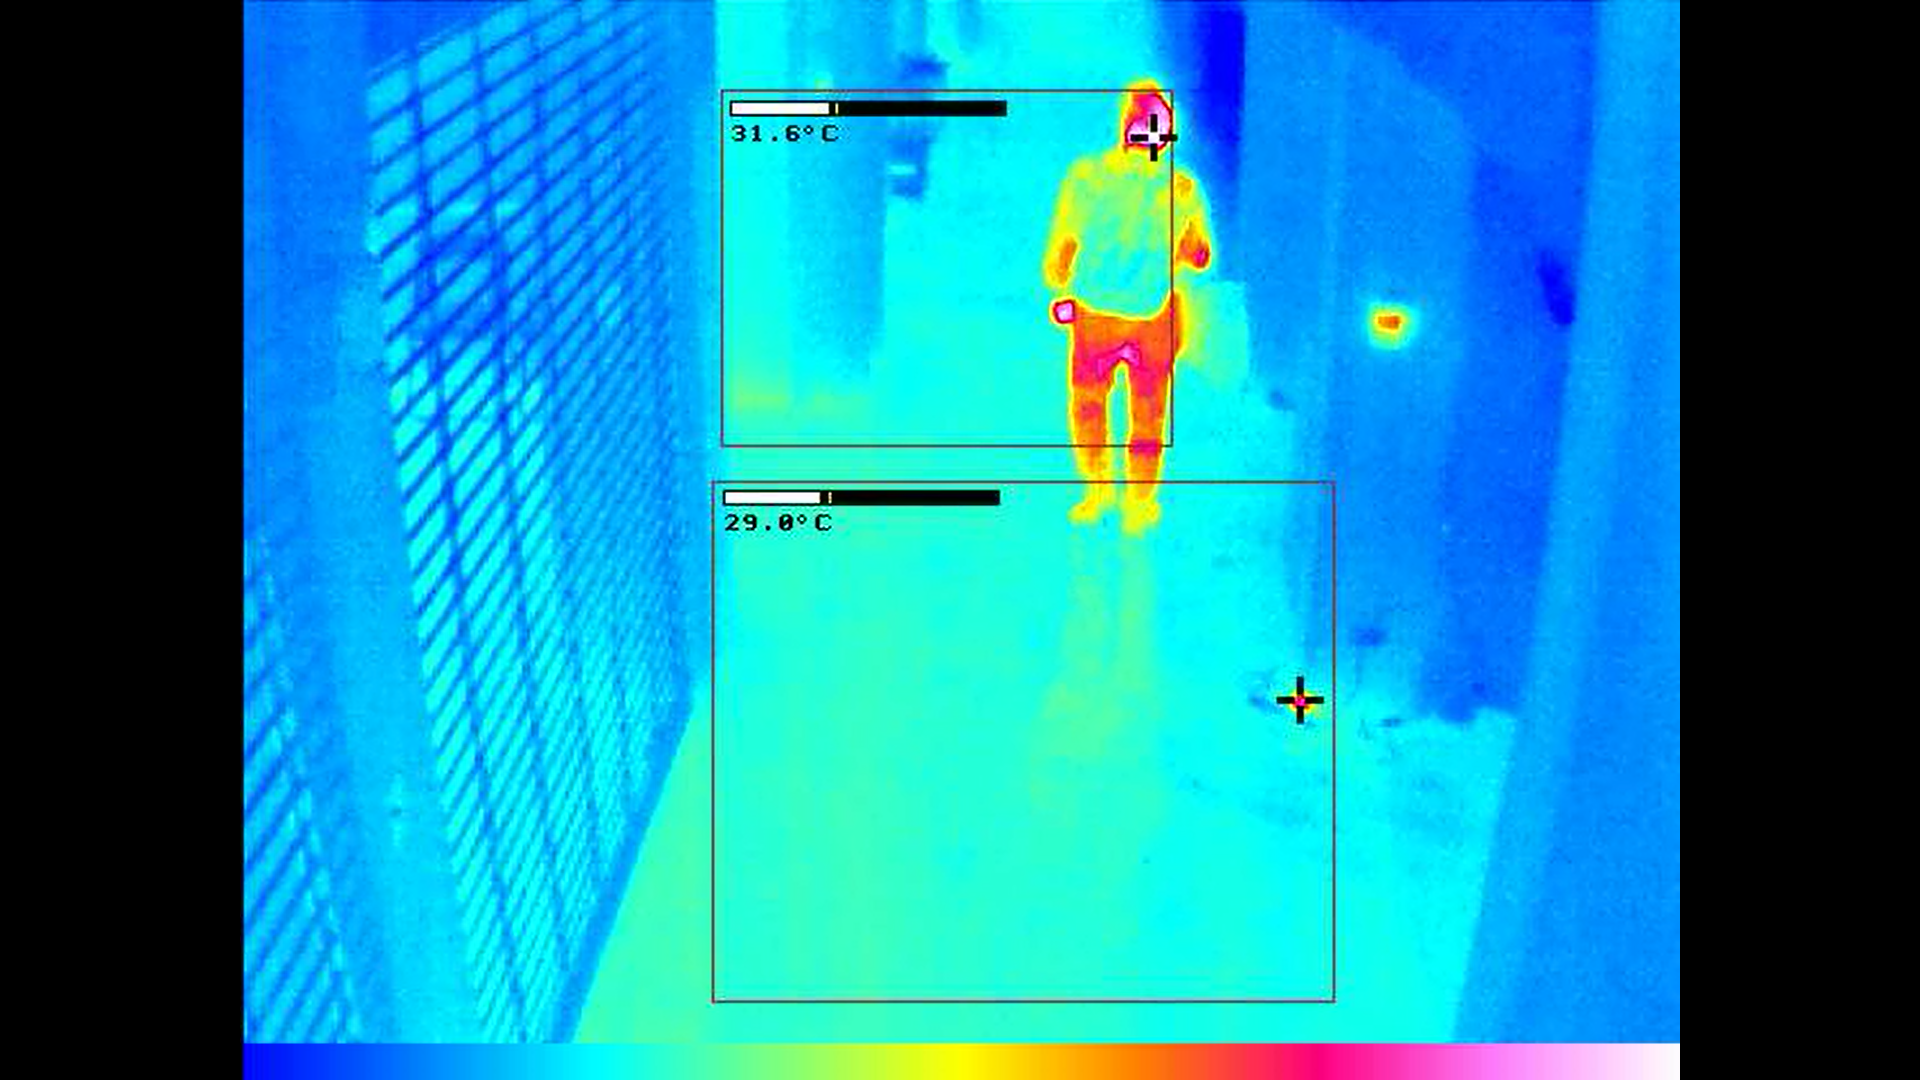

In [ ]:
from PIL import Image
Image.open('ThermalCHJHS/PNGImages/1.png')

# Create BBOX of heads

- [jupyter_bbox_widget](https://github.com/gereleth/jupyter-bbox-widget)
- [LabelImg](https://github.com/tzutalin/labelImg)

In [ ]:
# !pip install jupyter_bbox_widget

In [ ]:
# from jupyter_bbox_widget import BBoxWidget

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
# Failed...
# It seems Colab has some problems.
# widget = BBoxWidget(
#     image='./PennFudanPed/PNGImages/FudanPed00001.png',
#     classes=['head'],
# )
# widget

In [ ]:
# Parsing VOC XML format
# https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
import xml.etree.ElementTree as ET

def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

So each image has a corresponding label with VOC XML format. 

Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

import pdb

class ThremalDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.lbls = list(sorted(os.listdir(os.path.join(root, "Labels"))))
        assert [x.split(".")[0] for x in self.imgs] \
                == [y.split(".")[0] for y in self.lbls]

    def __getitem__(self, idx):
        # load images ad VOC XML labels
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        lbl_path = os.path.join(self.root, "Labels", self.lbls[idx])
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates for each image
        _, lbl = read_content(lbl_path)
        num_objs = len(lbl)
        boxes = []
        for i in range(num_objs):
            bbox = lbl[i]  # [xmin, ymin, xmax, ymax]
            xmin = bbox[0]
            xmax = bbox[2]
            ymin = bbox[1]
            ymax = bbox[3]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def _get_img_path(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        return img_path

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = ThremalDataset('ThermalCHJHS')
dataset[4]

(<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7FED21410A50>,
 {'area': tensor([18176., 17375., 17640.,  6840.,  7440.]),
  'boxes': tensor([[ 409.,  500.,  537.,  642.],
          [ 631.,  308.,  756.,  447.],
          [1350.,  708., 1476.,  848.],
          [ 936.,  308., 1012.,  398.],
          [1155.,  153., 1248.,  233.]]),
  'image_id': tensor([4]),
  'iscrowd': tensor([0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1])})

In [ ]:
np.array(dataset[0][0]).shape

(1080, 1920, 3)

In [ ]:
len(dataset)

797

In [ ]:
dataset._get_img_path(16)

'ThermalCHJHS/PNGImages/1013.png'

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels`.

## Defining your model

In this tutorial, we will use [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An object detection model

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the object detection bounding box, so we will be using Faster R-CNN:

# Pretrained model

- [fasterrcnn_resnet50_fpn](https://pytorch.org/vision/main/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)
    - Bounding Box
    - Mask Generation

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 135639, done.
remote: Counting objects: 100% (1859/1859), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 135639 (delta 1679), reused 1804 (delta 1667), pack-reused 133780
Receiving objects: 100% (135639/135639), 266.70 MiB | 21.54 MiB/s, done.
Resolving deltas: 100% (119181/119181), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = ThremalDataset('ThermalCHJHS', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1 + 1

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = ThremalDataset('ThermalCHJHS', get_transform(train=True))
dataset_test = ThremalDataset('ThermalCHJHS', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_trn = torch.utils.data.Subset(dataset, indices[:-3])
dataset_tst = torch.utils.data.Subset(dataset_test, indices[-3:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_trn, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_tst, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model and the optimizer

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/397]  eta: 0:20:13  lr: 0.000018  loss: 1.0116 (1.0116)  loss_classifier: 0.6363 (0.6363)  loss_box_reg: 0.1602 (0.1602)  loss_objectness: 0.1931 (0.1931)  loss_rpn_box_reg: 0.0220 (0.0220)  time: 3.0573  data: 0.9235  max mem: 2582
Epoch: [0]  [ 10/397]  eta: 0:11:46  lr: 0.000144  loss: 0.9797 (0.9345)  loss_classifier: 0.5710 (0.5239)  loss_box_reg: 0.2138 (0.1813)  loss_objectness: 0.1956 (0.2079)  loss_rpn_box_reg: 0.0260 (0.0214)  time: 1.8252  data: 0.1010  max mem: 2845
Epoch: [0]  [ 20/397]  eta: 0:11:10  lr: 0.000270  loss: 0.8131 (0.8535)  loss_classifier: 0.3690 (0.4214)  loss_box_reg: 0.2226 (0.2608)  loss_objectness: 0.1312 (0.1495)  loss_rpn_box_reg: 0.0214 (0.0217)  time: 1.7155  data: 0.0189  max mem: 2845
Epoch: [0]  [ 30/397]  eta: 0:10:41  lr: 0.000396  loss: 0.6811 (0.8107)  loss_classifier: 0.2616 (0.3703)  loss_box_reg: 0.3344 (0.2948)  loss_objectness: 0.0653 (0.1244)  loss_rpn_box_reg: 0.0203 (0.0211)  time: 1.7065  data: 0.0198  max mem: 2845


# How to intrepret the metric

- [How do I interpret evaluation results on my custom dataset?](https://github.com/matterport/Mask_RCNN/issues/663#issuecomment-396551364)
- [Evaluating Object Detection Models Using Mean Average Precision (mAP)](https://blog.paperspace.com/mean-average-precision/)
- [TensorFlow Object Detection API使用问题小记](https://zhuanlan.zhihu.com/p/93905440)

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, lbl = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
dataset_test[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'area': tensor([7954.]),
  'boxes': tensor([[1107.,   71., 1189.,  168.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[1105.8804,   70.8255, 1186.2848,  165.1709]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9823], device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

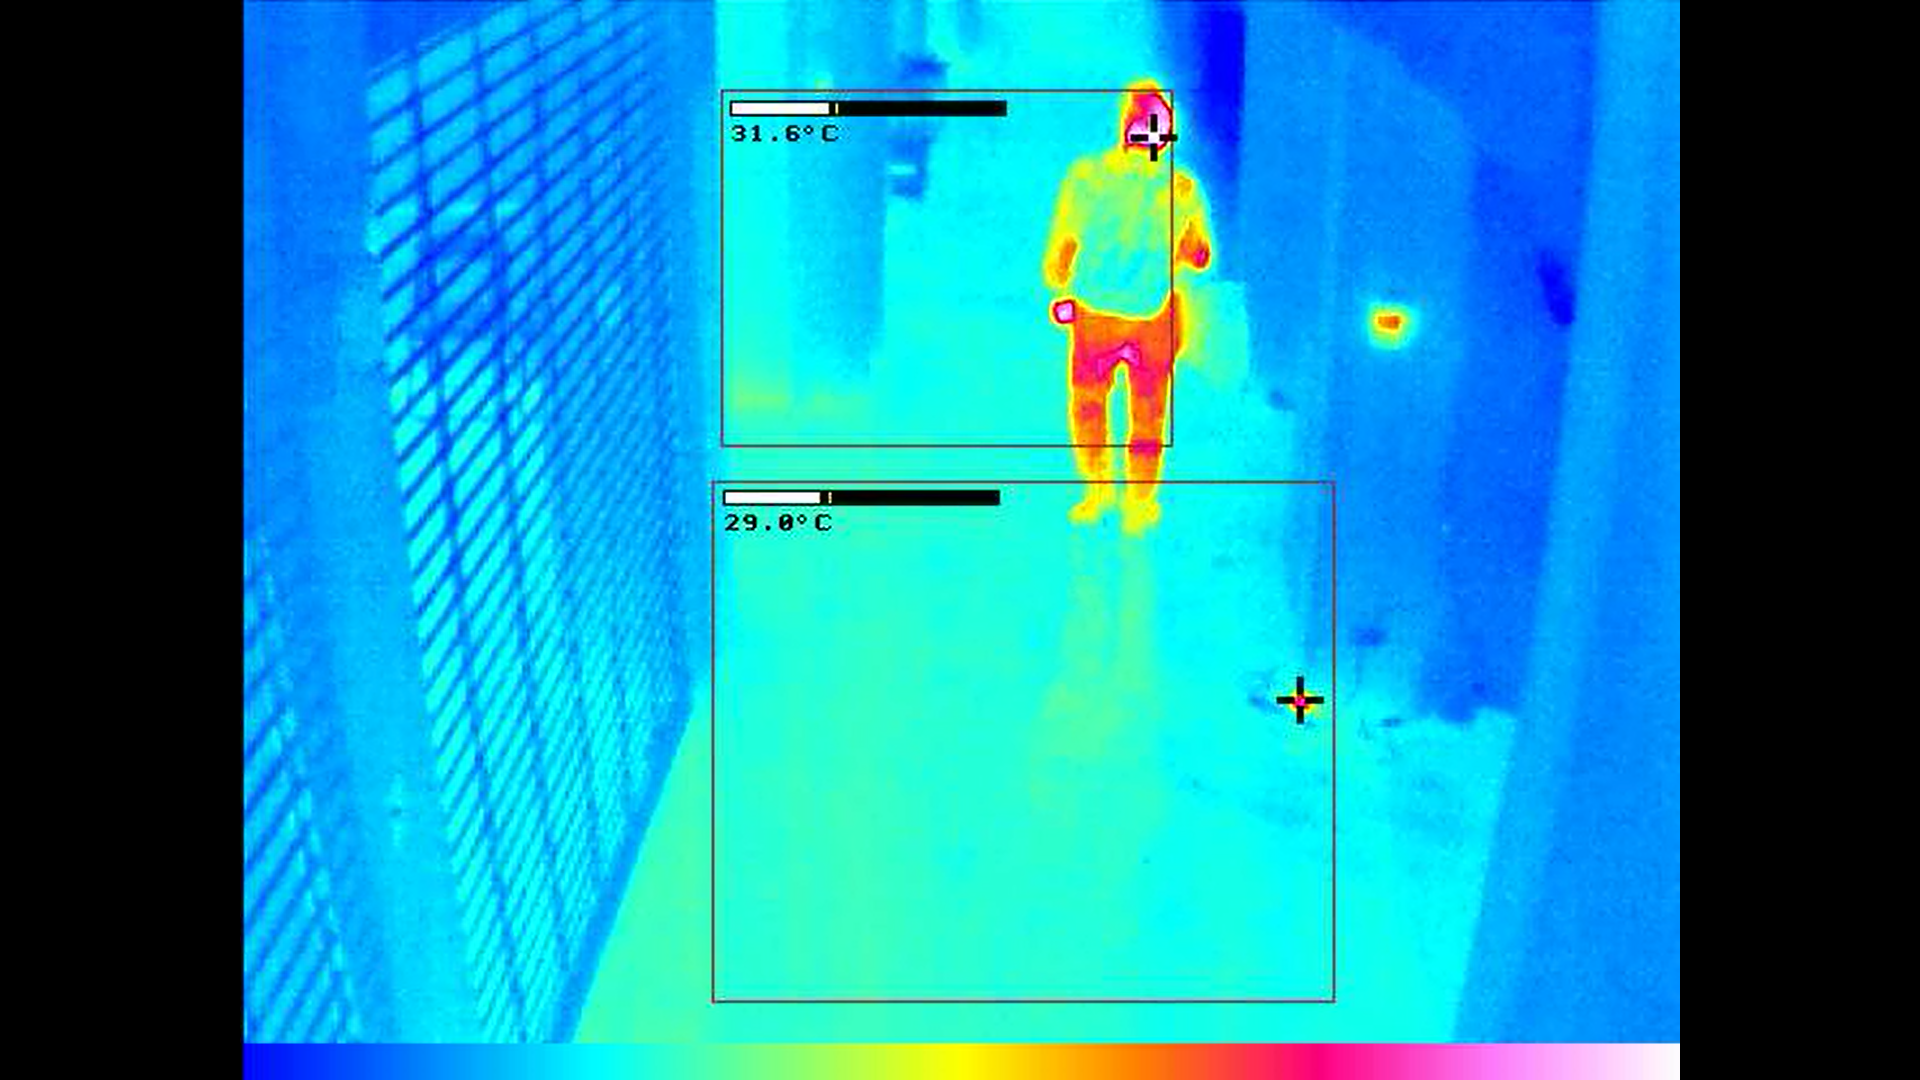

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
img_path = dataset_test._get_img_path(10)
print(img_path)

ThermalCHJHS/PNGImages/1008.png


And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

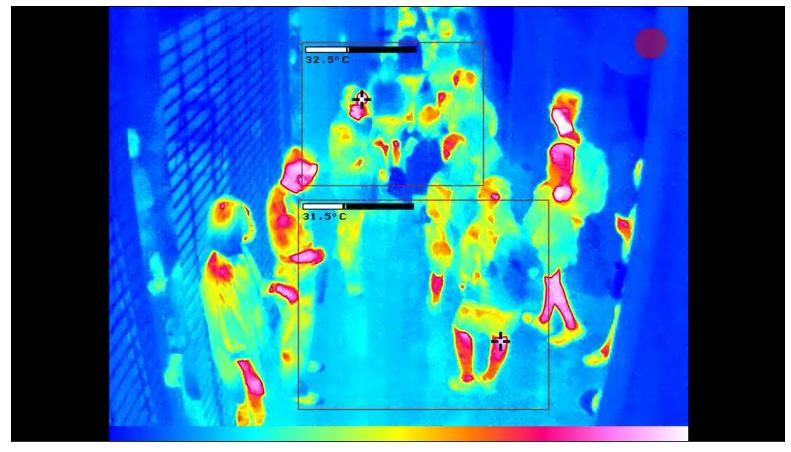

In [ ]:
from torchvision.io import read_image
from pathlib import Path
from torchvision import transforms
tst_img1 = read_image(img_path)
show(tst_img1)

In [ ]:
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import cv2

#tst_img1 = transforms.ToPILImage(tst_img1)
print(type(tst_img1))
#tst_img1 = cv2.cvtColor(np.float32(tst_img1), cv2.COLOR_BGR2RGB)
colors = ["blue", "yellow"]
# Observe the max number of people here.
max_head = 10
result = draw_bounding_boxes(tst_img1, 
                             prediction[0]["boxes"][:max_head],
                             #colors=colors, 
                             width=5)
result1 = transforms.ToPILImage(result)
show(result)

<class 'torch.Tensor'>


ValueError: ignored

Looks not good!

## How could we improve it?

1. Reformulate our problem.
2. Prepare more better datasets.
3. Try different image transform, DIP.
4. Design CNN model.
5. Tune hyper-parameters.
6. ...

In [ ]:
%%shell
pip show torchvision